# Notebook: Inference - Tomato Disease Prediction

**Project:** DeepSpec-Tomato: A Dual-Stage CAE-CNN Diagnostic Framework  
**Author:** Muhammad Ali Tahir  
**Date:** 2025  

---

## 📋 Notebook Purpose

This notebook provides a **production-ready inference pipeline** for predicting tomato leaf diseases using the trained CAE-CNN model.

### Features:
- Single image prediction
- Batch prediction (folder of images)
- Confidence scores with visualization
- Top-K predictions
- Exportable results (CSV/JSON)

---

## 1. Setup & Model Loading

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

import os
import json
import warnings
from pathlib import Path
from datetime import datetime
from typing import Union, List, Tuple, Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# Suppress warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Notebook executed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

PyTorch version: 2.7.0+cu128
CUDA available: True
Notebook executed at: 2026-01-28 12:06:38


In [3]:
# =============================================================================
# PROJECT PATHS
# =============================================================================

class ProjectPaths:
    """Centralized path management."""
    
    ROOT = Path("/home/maliciit/ml-projects/python-projects/plant-village-cae")
    DATA_PROCESSED = ROOT / "data" / "processed"
    MODELS = ROOT / "models"
    OUTPUTS = ROOT / "outputs"
    CONFIG = ROOT / "config"

PATHS = ProjectPaths()

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# =============================================================================
# MODEL ARCHITECTURE (Must match training)
# =============================================================================

class Encoder(nn.Module):
    """Encoder from CAE."""
    
    def __init__(self, latent_channels=128):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, latent_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(latent_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.encoder(x)


class TomatoClassifier(nn.Module):
    """Classification model."""
    
    def __init__(self, encoder, num_classes, hidden_dim=512, dropout=0.4):
        super(TomatoClassifier, self).__init__()
        
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)
    
    def predict_proba(self, x):
        """Return softmax probabilities."""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

In [5]:
# =============================================================================
# LOAD TRAINED MODEL
# =============================================================================

def load_model(model_path: Path, device: torch.device) -> Tuple[TomatoClassifier, Dict]:
    """
    Load trained model and its configuration.
    
    Args:
        model_path: Path to the saved model (.pth)
        device: Device to load model on
    
    Returns:
        Tuple of (model, config_dict)
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract configuration
    num_classes = checkpoint['num_classes']
    class_names = checkpoint['class_names']
    image_size = checkpoint['image_size']
    norm_mean = checkpoint['normalization']['mean']
    norm_std = checkpoint['normalization']['std']
    
    # Build model
    encoder = Encoder(latent_channels=128)
    model = TomatoClassifier(
        encoder=encoder,
        num_classes=num_classes,
        hidden_dim=512,
        dropout=0.4
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    config = {
        'num_classes': num_classes,
        'class_names': class_names,
        'class_names_raw': checkpoint.get('class_names_raw', class_names),
        'image_size': image_size,
        'norm_mean': norm_mean,
        'norm_std': norm_std,
        'best_f1': checkpoint.get('best_f1', None),
        'best_accuracy': checkpoint.get('best_accuracy', None)
    }
    
    return model, config

# Load model
MODEL_PATH = PATHS.MODELS / 'classifier_final.pth'
model, model_config = load_model(MODEL_PATH, DEVICE)

print(f"✓ Model loaded from: {MODEL_PATH}")
print(f"\n  Number of classes: {model_config['num_classes']}")
print(f"  Image size: {model_config['image_size']}×{model_config['image_size']}")
print(f"  Best F1 (training): {model_config['best_f1']:.4f}")
print(f"  Best Accuracy (training): {model_config['best_accuracy']:.2%}")
print(f"\n  Classes:")
for i, name in enumerate(model_config['class_names']):
    print(f"    [{i}] {name}")

✓ Model loaded from: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/classifier_final.pth

  Number of classes: 10
  Image size: 128×128
  Best F1 (training): 0.9774
  Best Accuracy (training): 97.63%

  Classes:
    [0] Bacterial Spot
    [1] Early Blight
    [2] Late Blight
    [3] Leaf Mold
    [4] Septoria Leaf Spot
    [5] Spider Mites Two-Spotted Spider Mite
    [6] Target Spot
    [7] Tomato Yellow Leaf Curl Virus
    [8] Tomato Mosaic Virus
    [9] Healthy


---

## 2. Inference Pipeline

In [6]:
# =============================================================================
# PREPROCESSING TRANSFORM
# =============================================================================

def get_inference_transform(image_size: int, mean: List[float], std: List[float]):
    """
    Create preprocessing transform for inference.
    
    Args:
        image_size: Target image size
        mean: Normalization mean (from training set)
        std: Normalization std (from training set)
    
    Returns:
        torchvision.transforms.Compose
    """
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

# Create transform
inference_transform = get_inference_transform(
    model_config['image_size'],
    model_config['norm_mean'],
    model_config['norm_std']
)

print("✓ Inference transform created")
print(f"  Normalization mean: {model_config['norm_mean']}")
print(f"  Normalization std: {model_config['norm_std']}")

✓ Inference transform created
  Normalization mean: [0.45038148760795593, 0.4661545753479004, 0.4010584056377411]
  Normalization std: [0.17417825758457184, 0.1513632982969284, 0.19069136679172516]


In [7]:
# =============================================================================
# TOMATO DISEASE PREDICTOR CLASS
# =============================================================================

class TomatoDiseasePredictor:
    """
    Production-ready predictor for tomato leaf disease classification.
    
    Usage:
        predictor = TomatoDiseasePredictor(model, config, device)
        result = predictor.predict('path/to/image.jpg')
        results = predictor.predict_batch('path/to/folder')
    """
    
    def __init__(self, model: nn.Module, config: Dict, device: torch.device):
        """
        Initialize predictor.
        
        Args:
            model: Trained PyTorch model
            config: Model configuration dict
            device: Device to run inference on
        """
        self.model = model
        self.config = config
        self.device = device
        self.class_names = config['class_names']
        self.num_classes = config['num_classes']
        
        # Create transform
        self.transform = get_inference_transform(
            config['image_size'],
            config['norm_mean'],
            config['norm_std']
        )
        
        # Ensure model is in eval mode
        self.model.eval()
    
    def _load_image(self, image_source: Union[str, Path, Image.Image]) -> Image.Image:
        """
        Load image from various sources.
        
        Args:
            image_source: Path string, Path object, or PIL Image
        
        Returns:
            PIL Image in RGB mode
        """
        if isinstance(image_source, Image.Image):
            img = image_source
        else:
            img = Image.open(image_source)
        
        # Convert to RGB if necessary
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        return img
    
    def _preprocess(self, image: Image.Image) -> torch.Tensor:
        """
        Preprocess image for model input.
        
        Args:
            image: PIL Image
        
        Returns:
            Preprocessed tensor [1, C, H, W]
        """
        tensor = self.transform(image)
        return tensor.unsqueeze(0).to(self.device)
    
    def predict(
        self, 
        image_source: Union[str, Path, Image.Image],
        top_k: int = 3,
        threshold: float = 0.0
    ) -> Dict:
        """
        Predict disease for a single image.
        
        Args:
            image_source: Path to image or PIL Image
            top_k: Number of top predictions to return
            threshold: Minimum confidence threshold (0-1)
        
        Returns:
            Dictionary with prediction results:
            {
                'predicted_class': str,
                'predicted_index': int,
                'confidence': float,
                'top_k_predictions': [(class_name, confidence), ...],
                'all_probabilities': {class_name: prob, ...},
                'is_confident': bool,
                'image_path': str
            }
        """
        # Load and preprocess
        image = self._load_image(image_source)
        input_tensor = self._preprocess(image)
        
        # Inference
        with torch.no_grad():
            probabilities = self.model.predict_proba(input_tensor)
        
        # Process results
        probs = probabilities.cpu().numpy()[0]
        
        # Get top-k predictions
        top_k_indices = np.argsort(probs)[::-1][:top_k]
        top_k_predictions = [
            (self.class_names[idx], float(probs[idx]))
            for idx in top_k_indices
        ]
        
        # Best prediction
        predicted_idx = int(top_k_indices[0])
        predicted_class = self.class_names[predicted_idx]
        confidence = float(probs[predicted_idx])
        
        # All probabilities
        all_probs = {name: float(probs[i]) for i, name in enumerate(self.class_names)}
        
        # Image path (if applicable)
        img_path = str(image_source) if isinstance(image_source, (str, Path)) else "PIL Image"
        
        return {
            'predicted_class': predicted_class,
            'predicted_index': predicted_idx,
            'confidence': confidence,
            'top_k_predictions': top_k_predictions,
            'all_probabilities': all_probs,
            'is_confident': confidence >= threshold,
            'image_path': img_path
        }
    
    def predict_batch(
        self,
        folder_path: Union[str, Path],
        extensions: Tuple[str, ...] = ('.jpg', '.jpeg', '.png', '.bmp'),
        top_k: int = 1,
        threshold: float = 0.0
    ) -> pd.DataFrame:
        """
        Predict diseases for all images in a folder.
        
        Args:
            folder_path: Path to folder containing images
            extensions: Valid image extensions
            top_k: Number of top predictions per image
            threshold: Minimum confidence threshold
        
        Returns:
            DataFrame with predictions for all images
        """
        folder = Path(folder_path)
        
        if not folder.exists():
            raise FileNotFoundError(f"Folder not found: {folder}")
        
        # Find all images
        image_files = []
        for ext in extensions:
            image_files.extend(folder.glob(f'*{ext}'))
            image_files.extend(folder.glob(f'*{ext.upper()}'))
        
        if not image_files:
            print(f"⚠ No images found in {folder}")
            return pd.DataFrame()
        
        print(f"Processing {len(image_files)} images...")
        
        # Process each image
        results = []
        for img_path in image_files:
            try:
                result = self.predict(img_path, top_k=top_k, threshold=threshold)
                results.append({
                    'filename': img_path.name,
                    'predicted_class': result['predicted_class'],
                    'confidence': result['confidence'],
                    'is_confident': result['is_confident']
                })
            except Exception as e:
                print(f"  ⚠ Error processing {img_path.name}: {e}")
                results.append({
                    'filename': img_path.name,
                    'predicted_class': 'ERROR',
                    'confidence': 0.0,
                    'is_confident': False
                })
        
        return pd.DataFrame(results)
    
    def predict_with_visualization(
        self,
        image_source: Union[str, Path, Image.Image],
        top_k: int = 5,
        figsize: Tuple[int, int] = (12, 5)
    ) -> Dict:
        """
        Predict and visualize results.
        
        Args:
            image_source: Path to image or PIL Image
            top_k: Number of top predictions to show
            figsize: Figure size
        
        Returns:
            Prediction result dictionary
        """
        # Get prediction
        result = self.predict(image_source, top_k=top_k)
        
        # Load image for display
        image = self._load_image(image_source)
        
        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: Image
        axes[0].imshow(image)
        axes[0].axis('off')
        
        # Title with prediction
        title_color = 'green' if result['confidence'] > 0.8 else 'orange' if result['confidence'] > 0.5 else 'red'
        axes[0].set_title(
            f"Prediction: {result['predicted_class']}\n"
            f"Confidence: {result['confidence']:.1%}",
            fontsize=12, fontweight='bold', color=title_color
        )
        
        # Plot 2: Top-K probabilities
        top_k_names = [p[0] for p in result['top_k_predictions']]
        top_k_probs = [p[1] for p in result['top_k_predictions']]
        
        colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(top_k_names))]
        
        bars = axes[1].barh(top_k_names[::-1], top_k_probs[::-1], color=colors[::-1])
        axes[1].set_xlabel('Confidence', fontsize=11)
        axes[1].set_xlim(0, 1)
        axes[1].set_title('Top Predictions', fontsize=12, fontweight='bold')
        
        # Add percentage labels
        for bar, prob in zip(bars, top_k_probs[::-1]):
            axes[1].text(prob + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{prob:.1%}', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        return result

# Initialize predictor
predictor = TomatoDiseasePredictor(model, model_config, DEVICE)
print("\n✓ Predictor initialized and ready!")


✓ Predictor initialized and ready!


---

## 3. Single Image Prediction

In [8]:
# =============================================================================
# EXAMPLE: SINGLE IMAGE PREDICTION
# =============================================================================

# Option 1: Using a test image from the dataset
TEST_PATH = PATHS.DATA_PROCESSED / 'test'

# Get a sample image (handle multiple extensions)
sample_class = list(TEST_PATH.iterdir())[0]  # First class folder

# Find images with various extensions
image_extensions = ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']
sample_images = []
for ext in image_extensions:
    sample_images.extend(list(sample_class.glob(ext)))

if not sample_images:
    print(f"⚠ No images found in {sample_class}")
    print(f"  Contents: {list(sample_class.iterdir())[:5]}")
else:
    sample_image = sample_images[0]  # First image found
    
    print(f"Sample image: {sample_image}")
    print(f"True label: {sample_class.name}\n")
    
    # Predict
    result = predictor.predict(sample_image, top_k=5)
    
    # Display results
    print("="*50)
    print("PREDICTION RESULT")
    print("="*50)
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"\nTop 5 predictions:")
    for i, (cls, prob) in enumerate(result['top_k_predictions'], 1):
        print(f"  {i}. {cls}: {prob:.2%}")

Sample image: /home/maliciit/ml-projects/python-projects/plant-village-cae/data/processed/test/Tomato___Bacterial_spot/f2cfc53d-a165-47d5-a9ac-6877e52a97b6___GCREC_Bact.Sp 3804.JPG
True label: Tomato___Bacterial_spot

PREDICTION RESULT
Predicted class: Bacterial Spot
Confidence: 50.26%

Top 5 predictions:
  1. Bacterial Spot: 50.26%
  2. Target Spot: 32.96%
  3. Early Blight: 5.85%
  4. Spider Mites Two-Spotted Spider Mite: 4.92%
  5. Late Blight: 3.59%


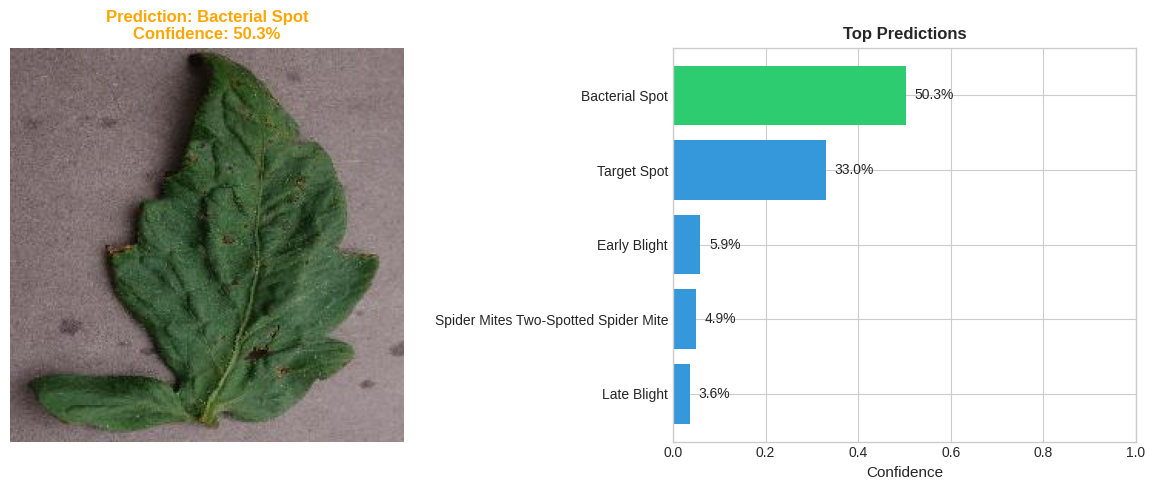

In [9]:
# =============================================================================
# PREDICTION WITH VISUALIZATION
# =============================================================================

# Predict and visualize
result = predictor.predict_with_visualization(sample_image, top_k=5)

✓ Figure saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/fig_inference_samples.png


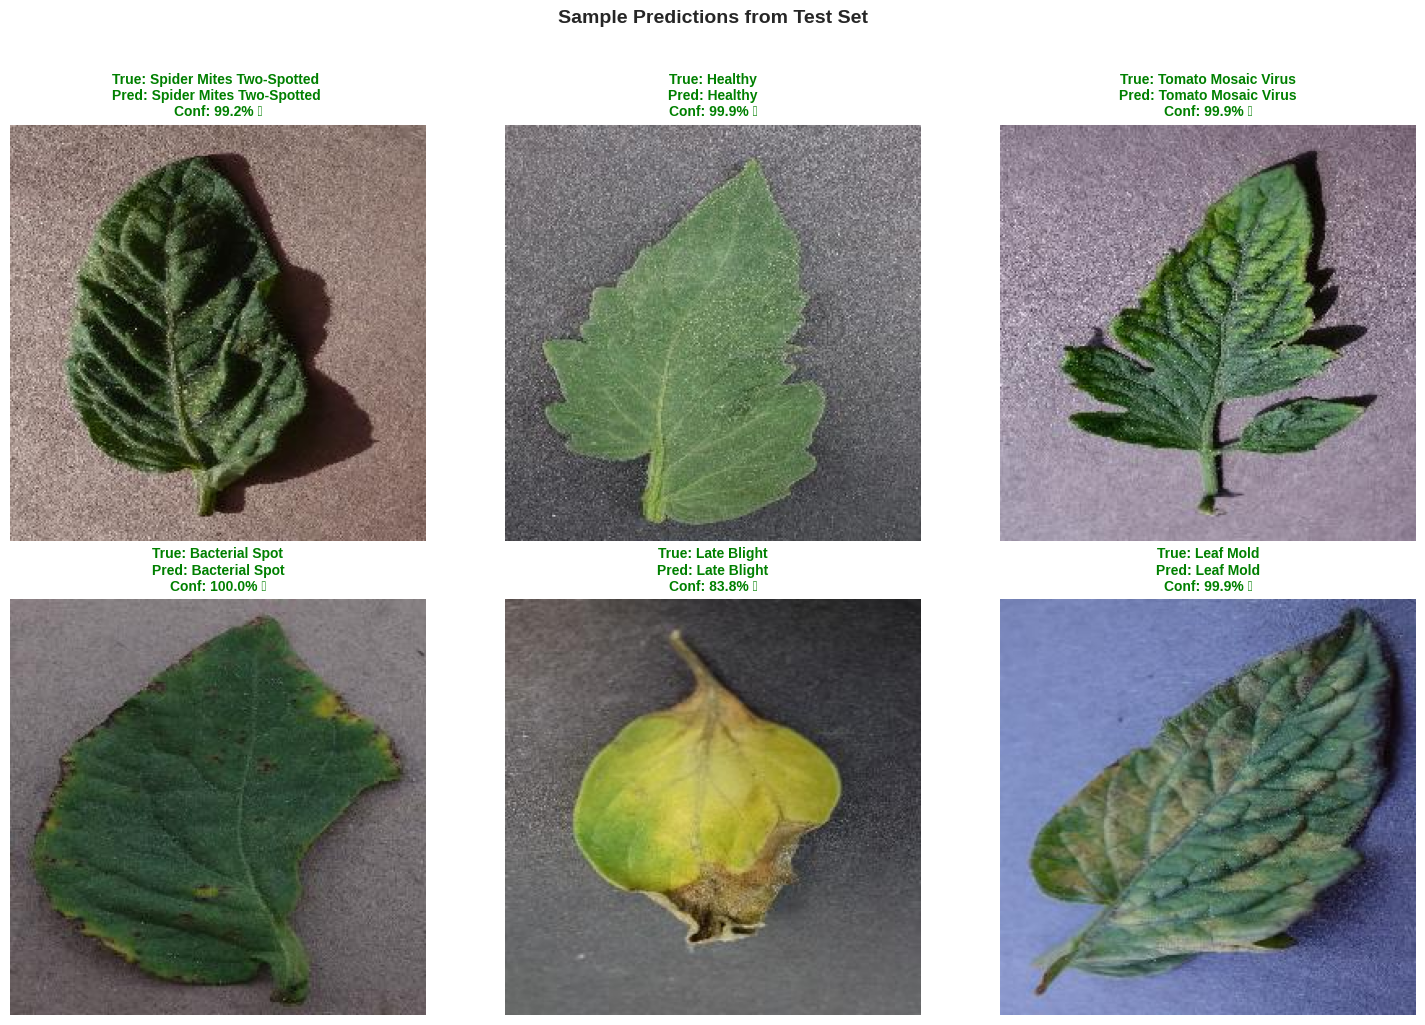

In [10]:
# =============================================================================
# MULTIPLE SAMPLE PREDICTIONS
# =============================================================================

def visualize_multiple_predictions(predictor, test_path, n_samples=6):
    """
    Visualize predictions for multiple random samples.
    """
    # Collect sample images from different classes
    samples = []
    class_folders = [f for f in test_path.iterdir() if f.is_dir()]
    
    np.random.seed(42)
    selected_folders = np.random.choice(class_folders, min(n_samples, len(class_folders)), replace=False)
    
    for class_folder in selected_folders:
        # Find images with various extensions
        images = []
        for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
            images.extend(list(class_folder.glob(ext)))
        
        if images:
            samples.append({
                'path': np.random.choice(images),
                'true_label': class_folder.name.split('___')[-1].replace('_', ' ').title()
            })
    
    if not samples:
        print("⚠ No samples found!")
        return
    
    # Create figure
    n_cols = 3
    n_rows = (len(samples) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, sample in enumerate(samples):
        # Predict
        result = predictor.predict(sample['path'])
        
        # Load image
        img = Image.open(sample['path'])
        
        # Display
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Check if correct (flexible matching)
        true_clean = sample['true_label'].lower().replace(' ', '').replace('-', '')
        pred_clean = result['predicted_class'].lower().replace(' ', '').replace('-', '')
        is_correct = true_clean in pred_clean or pred_clean in true_clean
        
        color = 'green' if is_correct else 'red'
        symbol = '✓' if is_correct else '✗'
        
        axes[i].set_title(
            f"True: {sample['true_label'][:25]}\n"
            f"Pred: {result['predicted_class'][:25]}\n"
            f"Conf: {result['confidence']:.1%} {symbol}",
            fontsize=10, color=color, fontweight='bold'
        )
    
    # Hide empty axes
    for j in range(len(samples), len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Sample Predictions from Test Set', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save figure
    fig_path = PATHS.OUTPUTS / 'fig_inference_samples.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Figure saved: {fig_path}")
    
    plt.show()

# Visualize
visualize_multiple_predictions(predictor, TEST_PATH, n_samples=6)

---

## 4. Batch Prediction

In [11]:
# =============================================================================
# BATCH PREDICTION ON A FOLDER
# =============================================================================

# Example: Predict on one class folder
sample_folder = list(TEST_PATH.iterdir())[0]
print(f"Running batch prediction on: {sample_folder.name}\n")

# Predict
batch_results = predictor.predict_batch(sample_folder, threshold=0.8)

# Display results
print(f"\n✓ Processed {len(batch_results)} images")
print(f"\nResults summary:")
print(batch_results.head(10))

# Statistics
print(f"\n" + "="*50)
print("BATCH STATISTICS")
print("="*50)
print(f"Total images: {len(batch_results)}")
print(f"Average confidence: {batch_results['confidence'].mean():.2%}")
print(f"Min confidence: {batch_results['confidence'].min():.2%}")
print(f"Max confidence: {batch_results['confidence'].max():.2%}")
print(f"Confident predictions (≥80%): {batch_results['is_confident'].sum()} ({batch_results['is_confident'].mean():.1%})")

Running batch prediction on: Tomato___Bacterial_spot

Processing 212 images...

✓ Processed 212 images

Results summary:
                                            filename predicted_class  \
0  f2cfc53d-a165-47d5-a9ac-6877e52a97b6___GCREC_B...  Bacterial Spot   
1  1b752a19-0731-4f93-b9ad-ca01fff2ab8b___GCREC_B...  Bacterial Spot   
2  25a8ea2f-8337-4b4b-8e2d-2110ee2b89ff___GCREC_B...  Bacterial Spot   
3  236e1153-9421-4a7a-bf51-e8e53f9ada22___UF.GRC_...  Bacterial Spot   
4  daa61ed9-a0bf-4533-841e-1a43633e86a1___GCREC_B...  Bacterial Spot   
5  ec7b4bc1-dd3e-4735-a90c-1d51831994a1___GCREC_B...  Bacterial Spot   
6  4293f140-6bbd-4e7b-af3e-f3d519d72524___GCREC_B...  Bacterial Spot   
7  ae52258c-eaab-4794-b6d5-601544d2e792___UF.GRC_...  Bacterial Spot   
8  eabeca07-9aa1-431a-92eb-be617775811d___UF.GRC_...  Bacterial Spot   
9  cfadf3d6-8988-4cd5-967d-589977eccd48___GCREC_B...  Bacterial Spot   

   confidence  is_confident  
0    0.502559         False  
1    0.999981          Tru

In [12]:
# =============================================================================
# EXPORT BATCH RESULTS TO CSV
# =============================================================================

# Save results
output_csv = PATHS.OUTPUTS / 'batch_predictions.csv'
batch_results.to_csv(output_csv, index=False)
print(f"✓ Results saved to: {output_csv}")

✓ Results saved to: /home/maliciit/ml-projects/python-projects/plant-village-cae/outputs/batch_predictions.csv


---

## 5. Custom Image Prediction

In [13]:
# =============================================================================
# PREDICT ON YOUR OWN IMAGE
# =============================================================================

# ⚠️ UNCOMMENT AND MODIFY THE PATH BELOW TO USE YOUR OWN IMAGE

# your_image_path = "/path/to/your/tomato_leaf_image.jpg"
# result = predictor.predict_with_visualization(your_image_path, top_k=5)

# print("\nFull prediction details:")
# print(json.dumps({k: v for k, v in result.items() if k != 'all_probabilities'}, indent=2))

print("To predict on your own image:")
print("1. Upload your image to this notebook environment")
print("2. Uncomment the code above")
print("3. Update 'your_image_path' with the correct path")
print("4. Run the cell")

To predict on your own image:
1. Upload your image to this notebook environment
2. Uncomment the code above
3. Update 'your_image_path' with the correct path
4. Run the cell


---

## 6. Export Predictor for Production

In [14]:
# =============================================================================
# EXPORT MODEL FOR PRODUCTION USE
# =============================================================================

def export_for_production(model, config, output_dir: Path):
    """
    Export model and configuration for production deployment.
    
    Creates:
    - model.pth (model weights)
    - config.json (model configuration)
    - inference.py (standalone inference script)
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. Save model weights only
    model_path = output_dir / 'model_weights.pth'
    torch.save(model.state_dict(), model_path)
    print(f"✓ Model weights saved: {model_path}")
    
    # 2. Save configuration
    config_path = output_dir / 'model_config.json'
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"✓ Configuration saved: {config_path}")
    
    # 3. Create standalone inference script
    inference_script = '''#!/usr/bin/env python3
"""
Standalone inference script for Tomato Disease Classification.

Usage:
    python inference.py --image path/to/image.jpg
    python inference.py --folder path/to/folder --output results.csv
"""

import argparse
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import pandas as pd


class Encoder(nn.Module):
    def __init__(self, latent_channels=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, latent_channels, 3, stride=2, padding=1), nn.BatchNorm2d(latent_channels), nn.ReLU(True),
        )
    def forward(self, x): return self.encoder(x)


class TomatoClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.encoder = Encoder()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 512), nn.BatchNorm1d(512), nn.ReLU(True), nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
    def forward(self, x): return self.classifier(self.encoder(x))


def load_model(model_dir):
    model_dir = Path(model_dir)
    with open(model_dir / "model_config.json") as f:
        config = json.load(f)
    model = TomatoClassifier(config["num_classes"])
    model.load_state_dict(torch.load(model_dir / "model_weights.pth", map_location="cpu"))
    model.eval()
    return model, config


def predict(model, config, image_path):
    transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(config["norm_mean"], config["norm_std"])
    ])
    img = Image.open(image_path).convert("RGB")
    tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        probs = F.softmax(model(tensor), dim=1)[0].numpy()
    idx = probs.argmax()
    return config["class_names"][idx], float(probs[idx])


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--model-dir", default=".", help="Directory with model files")
    parser.add_argument("--image", help="Single image path")
    parser.add_argument("--folder", help="Folder with images")
    parser.add_argument("--output", default="predictions.csv", help="Output CSV for batch")
    args = parser.parse_args()
    
    model, config = load_model(args.model_dir)
    
    if args.image:
        cls, conf = predict(model, config, args.image)
        print(f"Prediction: {cls} (Confidence: {conf:.1%})")
    elif args.folder:
        results = []
        for p in Path(args.folder).glob("*"):
            if p.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                cls, conf = predict(model, config, p)
                results.append({"file": p.name, "class": cls, "confidence": conf})
        pd.DataFrame(results).to_csv(args.output, index=False)
        print(f"Results saved to {args.output}")
'''
    
    script_path = output_dir / 'inference.py'
    with open(script_path, 'w') as f:
        f.write(inference_script)
    print(f"✓ Inference script saved: {script_path}")
    
    print(f"\n" + "="*50)
    print("PRODUCTION EXPORT COMPLETE")
    print("="*50)
    print(f"\nFiles exported to: {output_dir}")
    print("\nUsage:")
    print(f"  python {script_path} --model-dir {output_dir} --image your_image.jpg")
    print(f"  python {script_path} --model-dir {output_dir} --folder your_folder --output results.csv")

# Export
export_dir = PATHS.MODELS / 'production'
export_for_production(model, model_config, export_dir)

✓ Model weights saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/production/model_weights.pth
✓ Configuration saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/production/model_config.json
✓ Inference script saved: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/production/inference.py

PRODUCTION EXPORT COMPLETE

Files exported to: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/production

Usage:
  python /home/maliciit/ml-projects/python-projects/plant-village-cae/models/production/inference.py --model-dir /home/maliciit/ml-projects/python-projects/plant-village-cae/models/production --image your_image.jpg
  python /home/maliciit/ml-projects/python-projects/plant-village-cae/models/production/inference.py --model-dir /home/maliciit/ml-projects/python-projects/plant-village-cae/models/production --folder your_folder --output results.csv


---

## 7. Summary

### ✅ Inference Pipeline Features

| Feature | Description |
|---------|-------------|
| **Single Image** | `predictor.predict(image_path)` |
| **With Visualization** | `predictor.predict_with_visualization(image_path)` |
| **Batch Processing** | `predictor.predict_batch(folder_path)` |
| **Top-K Predictions** | Returns top K most likely classes |
| **Confidence Threshold** | Filter low-confidence predictions |
| **Export Results** | Save to CSV |

### 📁 Production Files

```
models/production/
├── model_weights.pth   # Lightweight weights file
├── model_config.json   # Configuration (classes, normalization)
└── inference.py        # Standalone CLI script
```

### 🚀 Next Steps

- Deploy with **FastAPI** or **Flask** for REST API
- Create **Gradio** or **Streamlit** web interface
- Convert to **ONNX** for cross-platform deployment
- Optimize with **TorchScript** for production

In [15]:
# =============================================================================
# NOTEBOOK COMPLETION
# =============================================================================

print("\n" + "="*60)
print("✓ INFERENCE NOTEBOOK COMPLETE")
print("="*60)
print(f"Execution finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nModel: {MODEL_PATH}")
print(f"Production export: {export_dir}")
print("\nReady for deployment!")


✓ INFERENCE NOTEBOOK COMPLETE
Execution finished at: 2026-01-28 12:06:49

Model: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/classifier_final.pth
Production export: /home/maliciit/ml-projects/python-projects/plant-village-cae/models/production

Ready for deployment!
